#list of youtube channels

1. Alex The Analyst

2. Thu Vu Analytics

3. Tableau Tim

4. Code Basics

5. Tina Huang

6. Krish Naik

7. Corey Schafer

8. Sundas Khalid

9. Luke Barousse

10. Kevin Stratvert

11. StatQuest with Josh Starmer 

12. Ken Jee

13. Sentdex

14. Adam Finer - Learn BI Online

15. keith galli

In [64]:
from googleapiclient.discovery import build
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from dateutil import parser
import isodate
from matplotlib.ticker import FuncFormatter

# 

# Data Collection

In [10]:
api_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

In [11]:
channel_id = ['UC7cs8q-gJRlGwj4A8OmCmXg',
              'UCJQJAI7IjbLcpsjWdSzYz0Q',
              'UC7HYxRWmaNlJux-X7rNLZyw',
              'UCh9nVJoWXmFb7sLApWGcLPQ',
              'UC2UXDak6o7rBm23k3Vv5dww',
              'UCNU_lfiiWBdtULKOw6X0Dig',
              'UCCezIgC97PvUuR4_gbFUs5g',
              'UCteRPiisgIoHtMgqHegpWAQ',
              'UCLLw7jmFsvfIVaUFsLs8mlQ',
              'UCfJT_eYDTmDE-ovKaxVE1ig',
              'UCtYLUTtgS3k1Fg4y5tAhLbw',
              'UCiT9RITQ9PW6BhXK0y2jaeg',
              'UCfzlCWGWYyIQ0aLC5w48gBQ',
              'UC1bhYMFuSFREIQ5bgclLDkQ',
              'UCq6XkhO5SZ66N04IcPbqNcw']
              

In [12]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [13]:
def get_channel_stats(youtube, channel_id):
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_id)
    )
    
    response = request.execute()
    
    #loop through items
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return(pd.DataFrame(all_data))

In [14]:
channel_data = get_channel_stats(youtube, channel_id)

In [15]:
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,Keith Galli,187000,12788428,77,UUq6XkhO5SZ66N04IcPbqNcw
1,sentdex,1210000,108354463,1236,UUfzlCWGWYyIQ0aLC5w48gBQ
2,Tina Huang,466000,19601798,118,UU2UXDak6o7rBm23k3Vv5dww
3,codebasics,750000,51637894,615,UUh9nVJoWXmFb7sLApWGcLPQ
4,Krish Naik,726000,71189341,1635,UUNU_lfiiWBdtULKOw6X0Dig
5,Tableau Tim,43400,2260561,379,UU7HYxRWmaNlJux-X7rNLZyw
6,Corey Schafer,1070000,83294660,231,UUCezIgC97PvUuR4_gbFUs5g
7,Kevin Stratvert,1980000,253133768,687,UUfJT_eYDTmDE-ovKaxVE1ig
8,Luke Barousse,322000,14577510,123,UULLw7jmFsvfIVaUFsLs8mlQ
9,Adam Finer - Learn BI Online,56900,2195143,58,UU1bhYMFuSFREIQ5bgclLDkQ


In [16]:
def get_video_ids(youtube, playlist_id):
    
    request = youtube.playlistItems().list(
        part= 'contentDetails',
         playlistId = playlist_id,
         maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
        next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

In [18]:
def get_video_details(youtube, video_ids):
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
            
    return pd.DataFrame(all_video_info)

In [20]:
video_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    
    video_df = video_df.append(video_data, ignore_index=True)

Getting video information from channel: Keith Galli


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: sentdex


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Tina Huang


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: codebasics


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Krish Naik


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Tableau Tim


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Corey Schafer


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Kevin Stratvert


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Luke Barousse


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Adam Finer - Learn BI Online


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Ken Jee


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: StatQuest with Josh Starmer


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Thu Vu data analytics


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Alex The Analyst


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Sundas Khalid


C:\Users\User\AppData\Local\Temp\ipykernel_5088\991497109.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


In [21]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,Ft9kV5OzMa0,Keith Galli,Full Data Science Mock Interview! (featuring K...,Check out Mobile Pixels! https://bit.ly/3WKUC5...,"[Keith Galli, python, programming, python 3, d...",2023-01-09T14:03:00Z,5766,232,None,41,PT1H27M34S,hd,false
1,TmTd7drDPDA,Keith Galli,Full Python Portfolio Project! Create a smart ...,Check out https://www.assemblyai.com/?utm_sour...,"[Keith Galli, python, programming, python 3, d...",2022-11-22T16:19:51Z,4741,180,None,34,PT1H20M39S,hd,false
2,cc0HOiKN_ac,Keith Galli,Solving Real-World Data Science Interview Ques...,Visit https://brilliant.org/KeithGalli/ to ge...,"[Keith Galli, python, programming, python 3, d...",2022-07-26T14:02:27Z,53290,1910,None,70,PT1H47M50S,hd,false
3,YuWZNV4BkkY,Keith Galli,5 Jupyter Notebook Tips & Tricks to Improve yo...,Visit https://brilliant.org/KeithGalli/ to get...,"[Keith Galli, python, programming, python 3, d...",2022-06-01T03:34:31Z,30804,1254,None,63,PT23M17S,hd,false
4,l-NAT4H4384,Keith Galli,Solving real world data science problems with ...,Practice your Python Pandas data science skill...,"[Keith Galli, python, programming, python 3, d...",2022-05-11T11:01:31Z,33548,776,None,45,PT1H21M38S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,dz9ufVkTq5w,Sundas Khalid,Highly recommend reading ‘The Simple Path to W...,Highly recommend reading ‘The Simple Path to W...,None,2020-10-28T01:35:46Z,5943,125,None,4,PT16S,hd,false
5946,K0yr0ZQ1_js,Sundas Khalid,How I Got into FAANG (Data Science),Hello friends!\n\nToday I’m talking about tips...,None,2020-09-27T16:00:10Z,14559,478,None,58,PT22M8S,hd,true
5947,Jwc2SPl7v3Y,Sundas Khalid,Want to be a Data Scientist? This is the First...,"In this video, I talk about the first thing yo...","[data science, women in tech, data scientist, ...",2020-09-08T15:00:11Z,25495,1107,None,50,PT4M11S,hd,true
5948,aZiQCz31J4E,Sundas Khalid,First Day at Google - New York Noogler New Hir...,Sharing my first day Google experience at the ...,"[First Day at Google, Googler, Noogler, Women ...",2020-08-21T15:00:01Z,55676,1078,None,89,PT20M14S,hd,true


In [22]:
def get_comments_in_videos(youtube, video_ids):
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)

In [25]:
comments_df = pd.DataFrame()

# get comment data
comments_data = get_comments_in_videos(youtube, video_ids)

# append video data together and comment data toghether
comments_df = comments_df.append(comments_data, ignore_index=True)

Could not get comments for video hAa__S85msc
Could not get comments for video 2fpDvYNo6fU


C:\Users\User\AppData\Local\Temp\ipykernel_5088\3733350203.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


In [26]:
comments_df

,video_id,comments
0,uOw6zxNaXH4,"[COOEL, MaashaAllah 👍]"
1,YiwOc5RON5w,"[Thanks for the Informative Video //, Only her..."
2,yi7yR1hzRkk,"[OMG, tnx for the tips., Keep it up dear ❤️, W..."
3,4n7e0PL17DQ,[tnx!\nI actually enjoy all three so hopefully...
4,VmdJ3qgyBDE,[The first 200 visitors to https://brilliant.o...
...,...,...
81,Tx8BxhKDCb8,[And what is your job exactly in Data science ...
82,dz9ufVkTq5w,"[Hii, Thank you miss🤍, Sundas Khalid..can you ..."
83,K0yr0ZQ1_js,[We did a live Q&A during this video premier. ...
84,Jwc2SPl7v3Y,"[Thanks! Very brief, short, but concise and in..."


# 

# Data Cleaning

In [27]:
video_df.isna().sum()

video_id             0
channelTitle         0
title                0
description          0
tags               457
publishedAt          0
viewCount            0
likeCount            8
favouriteCount    5950
commentCount         2
duration             0
definition           0
caption              0
dtype: int64

In [28]:
comments_df.isna().sum()

video_id    0
comments    0
dtype: int64

In [29]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [30]:
#Dropping favouritecount column as it is full of  null values


video_df = video_df.drop('favouriteCount', axis = 1)

In [31]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,Ft9kV5OzMa0,Keith Galli,Full Data Science Mock Interview! (featuring K...,Check out Mobile Pixels! https://bit.ly/3WKUC5...,"[Keith Galli, python, programming, python 3, d...",2023-01-09T14:03:00Z,5766,232,41,PT1H27M34S,hd,false
1,TmTd7drDPDA,Keith Galli,Full Python Portfolio Project! Create a smart ...,Check out https://www.assemblyai.com/?utm_sour...,"[Keith Galli, python, programming, python 3, d...",2022-11-22T16:19:51Z,4741,180,34,PT1H20M39S,hd,false
2,cc0HOiKN_ac,Keith Galli,Solving Real-World Data Science Interview Ques...,Visit https://brilliant.org/KeithGalli/ to ge...,"[Keith Galli, python, programming, python 3, d...",2022-07-26T14:02:27Z,53290,1910,70,PT1H47M50S,hd,false
3,YuWZNV4BkkY,Keith Galli,5 Jupyter Notebook Tips & Tricks to Improve yo...,Visit https://brilliant.org/KeithGalli/ to get...,"[Keith Galli, python, programming, python 3, d...",2022-06-01T03:34:31Z,30804,1254,63,PT23M17S,hd,false
4,l-NAT4H4384,Keith Galli,Solving real world data science problems with ...,Practice your Python Pandas data science skill...,"[Keith Galli, python, programming, python 3, d...",2022-05-11T11:01:31Z,33548,776,45,PT1H21M38S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...
5945,dz9ufVkTq5w,Sundas Khalid,Highly recommend reading ‘The Simple Path to W...,Highly recommend reading ‘The Simple Path to W...,None,2020-10-28T01:35:46Z,5943,125,4,PT16S,hd,false
5946,K0yr0ZQ1_js,Sundas Khalid,How I Got into FAANG (Data Science),Hello friends!\n\nToday I’m talking about tips...,None,2020-09-27T16:00:10Z,14559,478,58,PT22M8S,hd,true
5947,Jwc2SPl7v3Y,Sundas Khalid,Want to be a Data Scientist? This is the First...,"In this video, I talk about the first thing yo...","[data science, women in tech, data scientist, ...",2020-09-08T15:00:11Z,25495,1107,50,PT4M11S,hd,true
5948,aZiQCz31J4E,Sundas Khalid,First Day at Google - New York Noogler New Hir...,Sharing my first day Google experience at the ...,"[First Day at Google, Googler, Noogler, Women ...",2020-08-21T15:00:01Z,55676,1078,89,PT20M14S,hd,true


In [32]:
channel_data.dtypes

channelName    object
subscribers    object
views          object
totalVideos    object
playlistId     object
dtype: object

In [33]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce', axis = 1)


numeric_cols = ['viewCount', 'likeCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors= 'coerce', axis = 1)

In [38]:
# publish day in the week

video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [39]:
# convert duration to seconds

video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [40]:
# Add number of tags

video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [41]:
# Comments and likes per 1000 view ratio

video_df['likeRatio'] = video_df['likeCount']/video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/video_df['viewCount'] * 1000

# 

# Exploratory Data Analysis

# 1. No of Subscribers per Channels

In [47]:
sub_df = channel_data[['channelName', 'subscribers']].sort_values('subscribers', ascending=False)

sub_df

,channelName,subscribers
7,Kevin Stratvert,1980000
1,sentdex,1210000
6,Corey Schafer,1070000
11,StatQuest with Josh Starmer,890000
3,codebasics,750000
4,Krish Naik,726000
2,Tina Huang,466000
13,Alex The Analyst,401000
8,Luke Barousse,322000
10,Ken Jee,237000


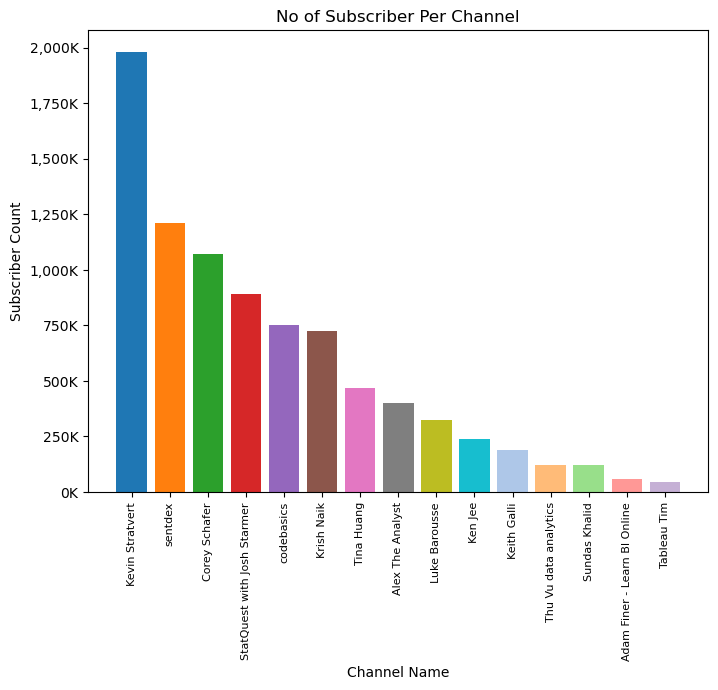

In [62]:
fig = plt.figure(figsize=(8, 6))

x = sub_df['channelName']

y = sub_df['subscribers']

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22',
         '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']

plt.bar(x, y, color=colors )

plt.xlabel('Channel Name')

plt.ylabel('Subscriber Count')

plt.title('No of Subscriber Per Channel')

plt.xticks(rotation= 'vertical', size=8)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000) + 'K'))

plt.show()


# 2. No of Views per Channels

In [54]:
view_df = channel_data[['channelName', 'views']].sort_values('views', ascending=False)

view_df

,channelName,views
7,Kevin Stratvert,253133768
1,sentdex,108354463
6,Corey Schafer,83294660
4,Krish Naik,71189341
3,codebasics,51637894
11,StatQuest with Josh Starmer,46225151
2,Tina Huang,19601798
13,Alex The Analyst,15552388
8,Luke Barousse,14577510
0,Keith Galli,12788428


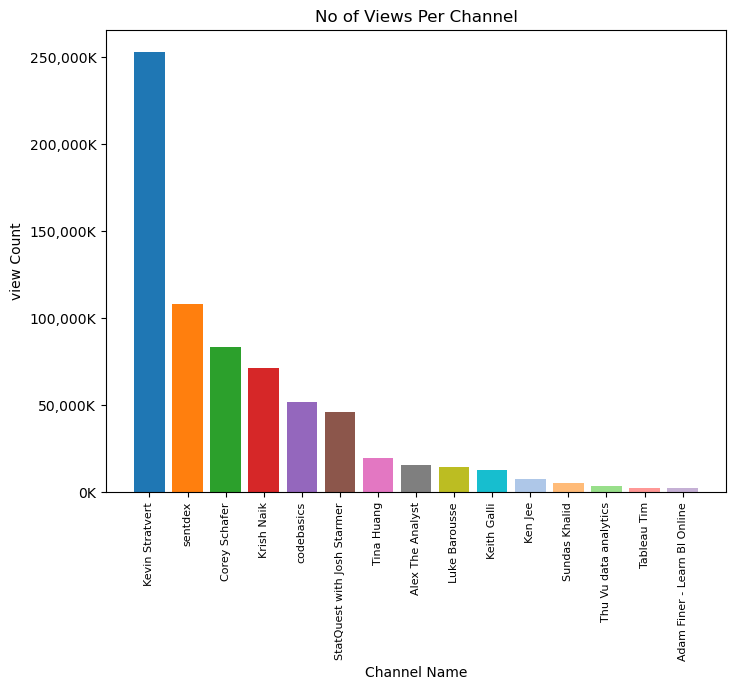

In [63]:
fig = plt.figure(figsize=(8, 6))

x = view_df['channelName']

y = view_df['views']

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22',
         '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']

plt.bar(x, y, color=colors )

plt.xlabel('Channel Name')

plt.ylabel('view Count')

plt.title('No of Views Per Channel')

plt.xticks(rotation= 'vertical', size=8)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000) + 'K'))

plt.show()

# 3. Views distribution per channel

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


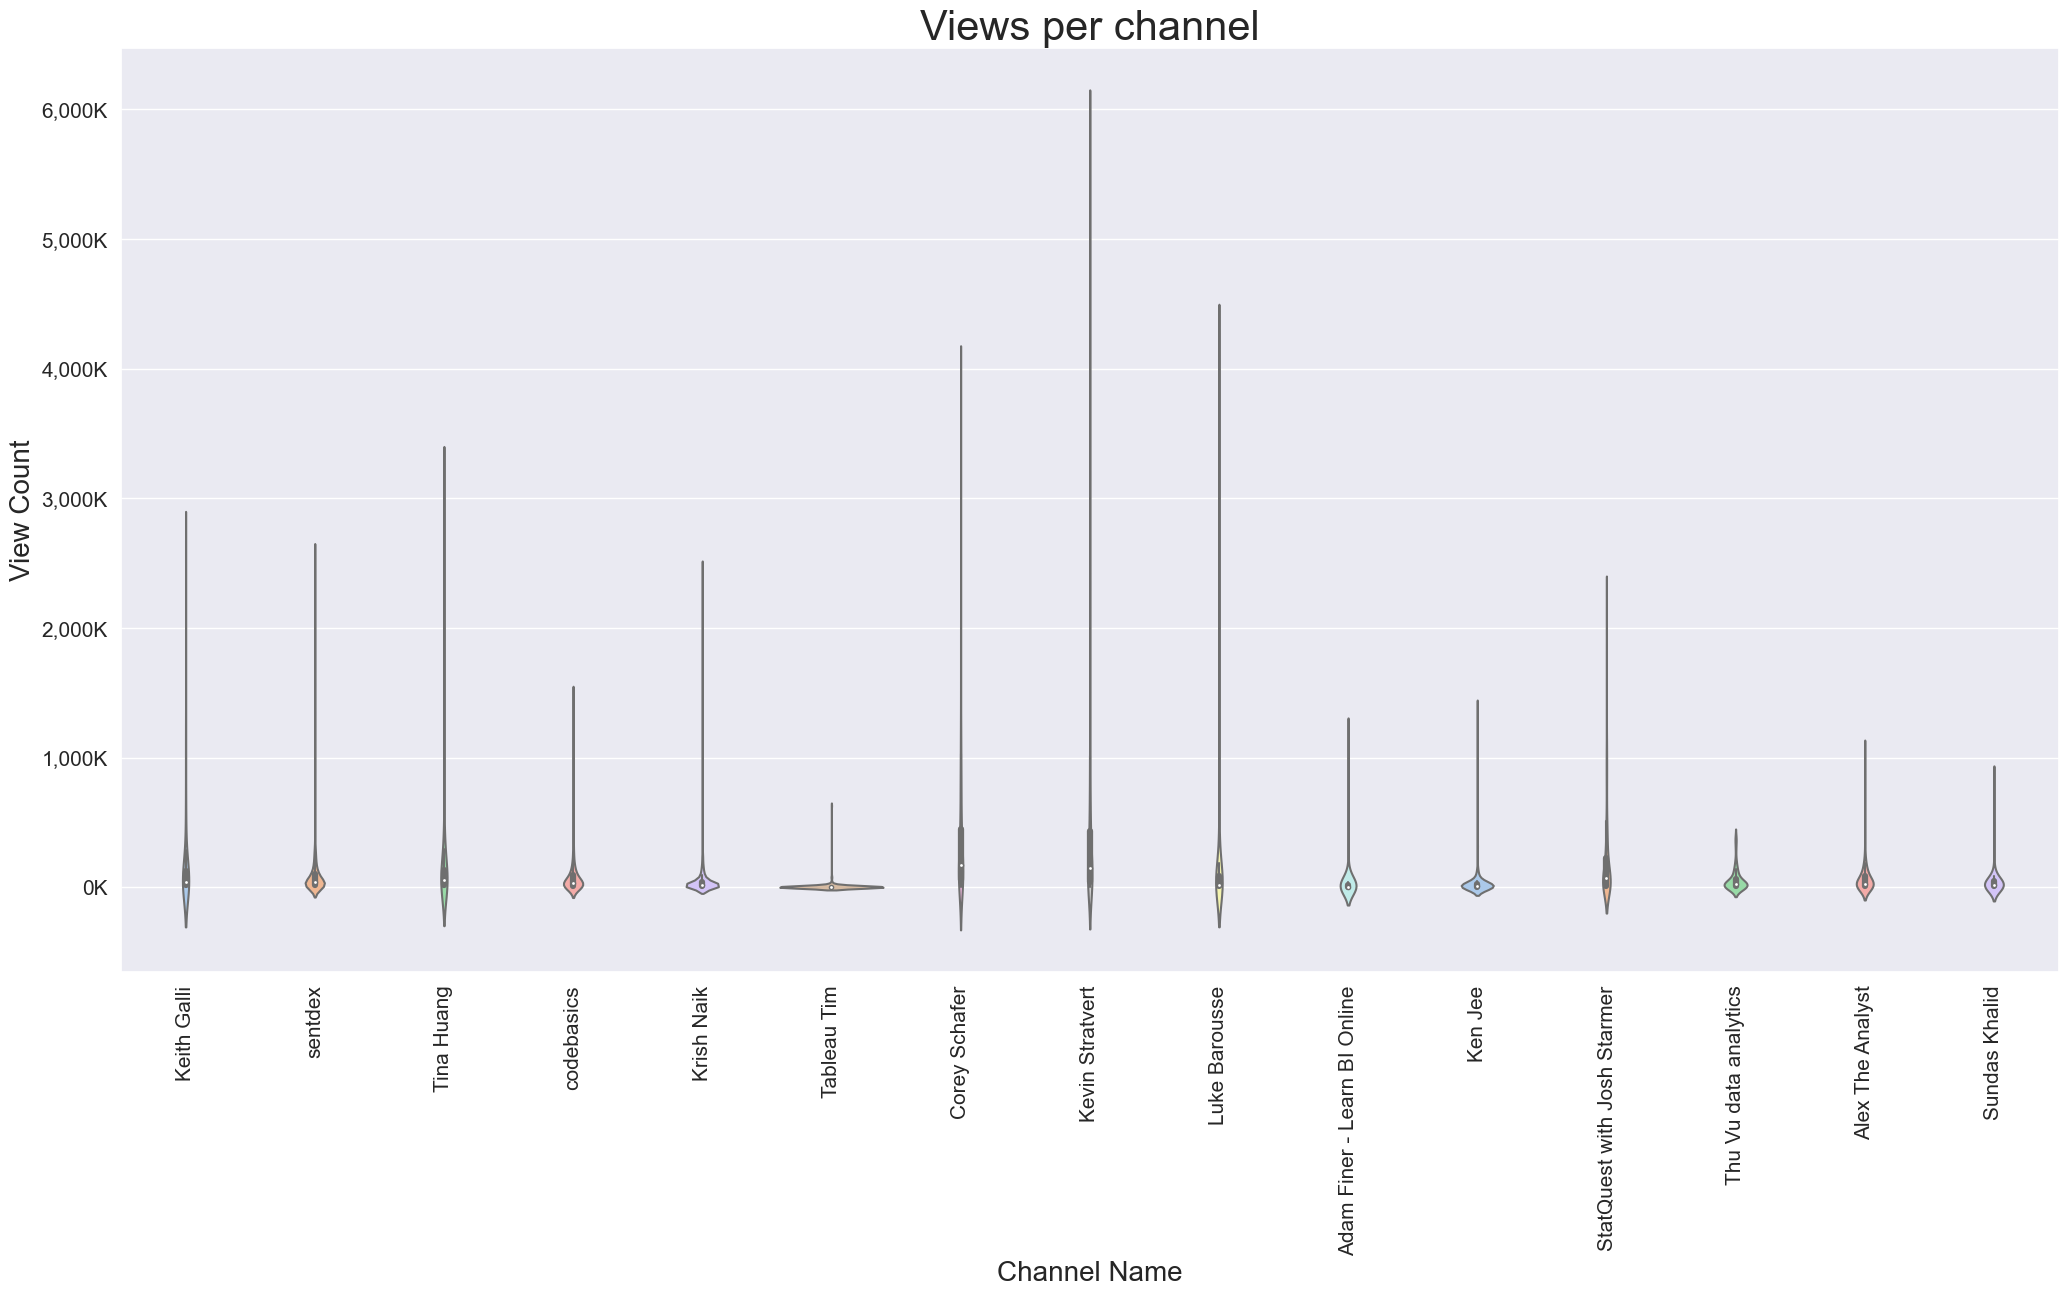

In [93]:
#plt.rcParmas['figure.figsize'] = (18, 6)

sns.set(style="darkgrid", color_codes=True)

fig = plt.figure(figsize=(25, 12))

sns.violinplot(video_df['channelTitle'], video_df['viewCount'], palette = 'pastel')

plt.xticks(rotation = 'vertical', size = 15)

plt.yticks(size = 15)

plt.xlabel('Channel Name', size= 20)

plt.ylabel('View Count', size= 20)

plt.title('Views per channel', fontsize = 30)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000) + 'K'))

plt.show()

# 4. Does the number of likes and comments matter for a video to get more views?

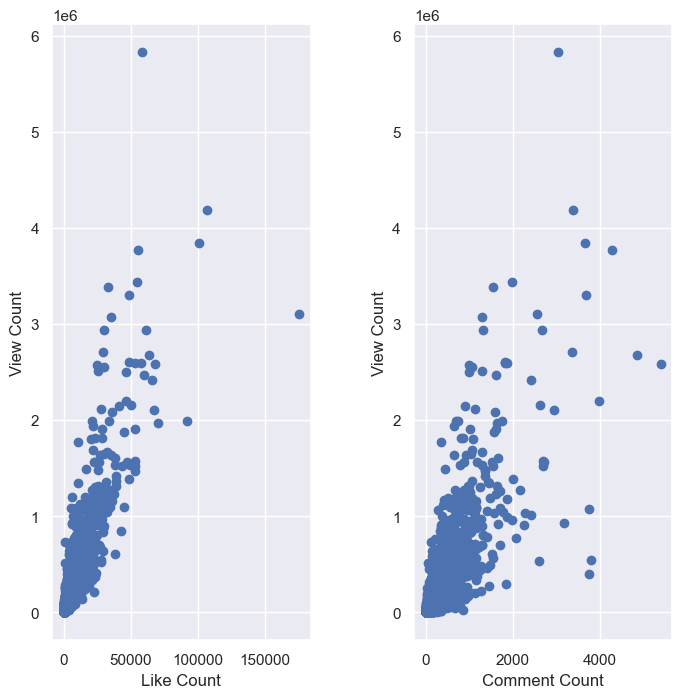

In [113]:
#correlation between no of views and likes, comments

x1 = video_df['likeCount']
y1 = video_df['viewCount']

x2 = video_df['commentCount']
y2 = video_df['viewCount']


fig, axs = plt.subplots(1, 2, figsize=(8, 8))


axs[0].scatter(x1, y1)
axs[0].set_xlabel('Like Count', fontsize=12)
axs[0].set_ylabel('View Count', fontsize=12)


axs[1].scatter(x2, y2)
axs[1].set_xlabel('Comment Count', fontsize=12)
axs[1].set_ylabel('View Count', fontsize=12)


fig.subplots_adjust(wspace=0.4)


plt.show()


<AxesSubplot:xlabel='likeRatio', ylabel='viewCount'>

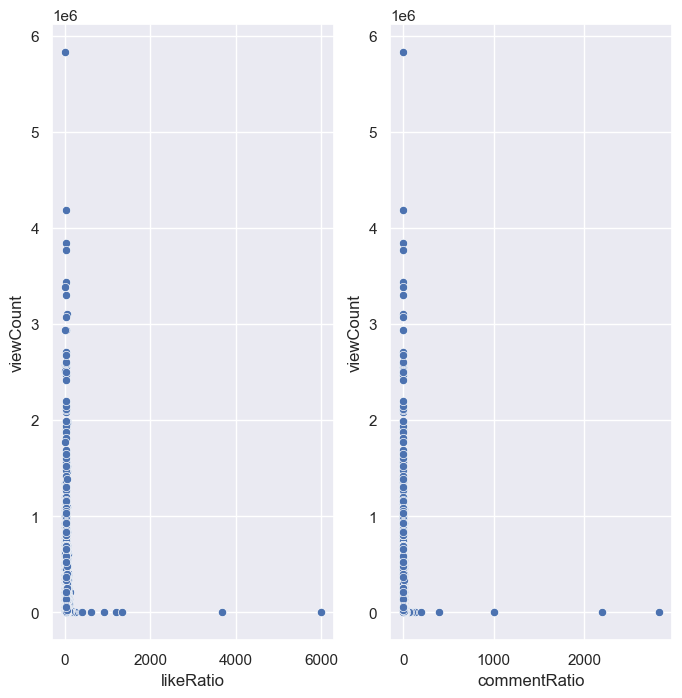

In [114]:
#correlation if we look at the comment ratio and like ratio 

fig, ax =plt.subplots(1,2, figsize=(8, 8))
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[1])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[0])

# 5. Like and Dislike Ratio

Text(0, 0.5, 'Total Likes')

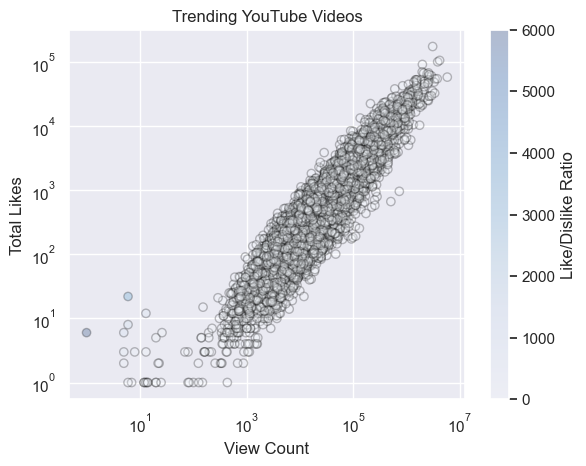

In [112]:
view_count = video_df['viewCount']
likes = video_df['likeCount']
ratio = video_df['likeRatio']

plt.scatter(view_count, likes, c=ratio, cmap= 'Blues', edgecolor= 'black', alpha = 0.25)

cbar= plt.colorbar()
cbar.set_label('Like/Dislike Ratio')

plt.xscale('log')
plt.yscale('log')

plt.title('Trending YouTube Videos')
plt.xlabel('View Count')
plt.ylabel('Total Likes')

# 6. Does title length matter for views?

In [108]:
video_df['titleLen'] = video_df['title'].apply(lambda x: len(x))

video_df['titleLen']

0       56
1       92
2       73
3       71
4       79
        ..
5945    80
5946    35
5947    67
5948    59
5949    25
Name: titleLen, Length: 5950, dtype: int64

<AxesSubplot:xlabel='titleLen', ylabel='viewCount'>

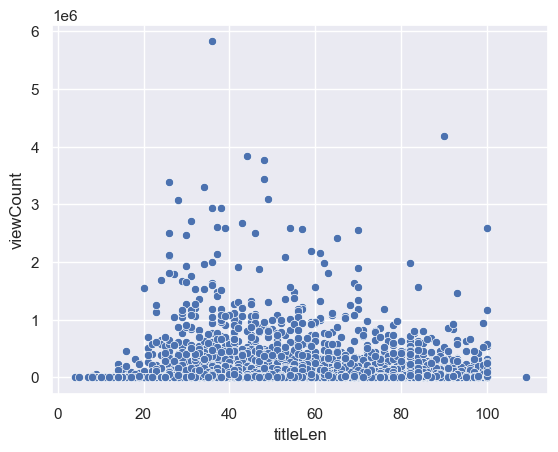

In [110]:
sns.scatterplot(data = video_df, x = "titleLen", y = "viewCount")

# 7. Does the video duration matter for views and interaction (likes/ comments)?

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

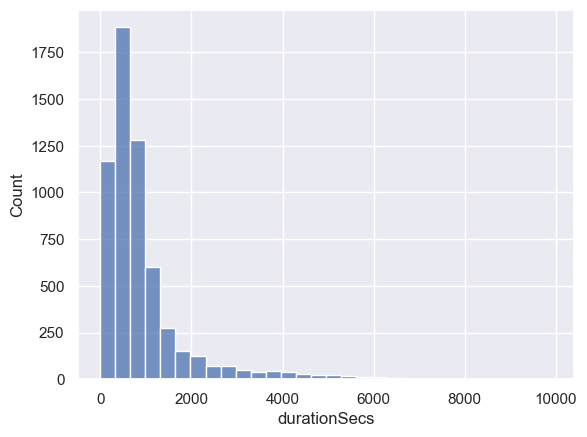

In [118]:
#first let's see the average video duration

sns.histplot(data=video_df[video_df['durationSecs'] < 10000], x="durationSecs", bins=30)

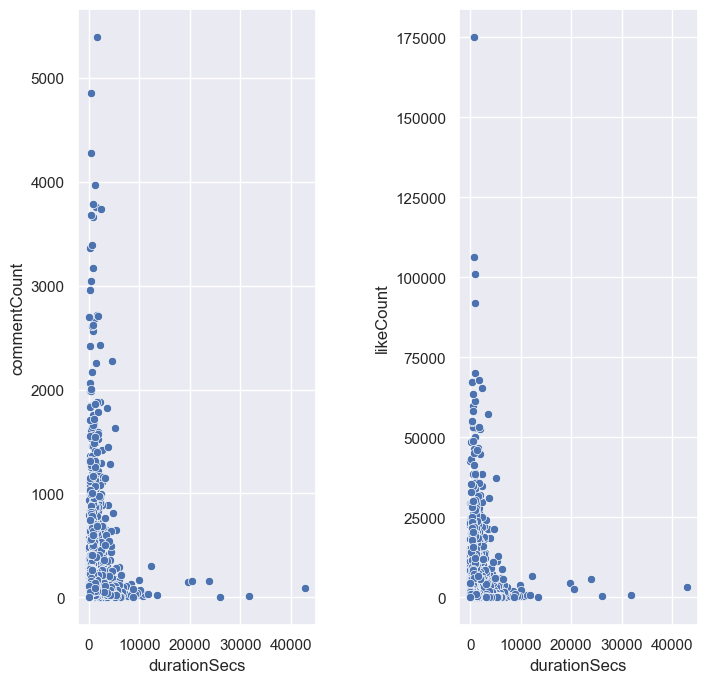

In [121]:
#now let;s plot relation between duration and likes, comments

fig, ax =plt.subplots(1,2, figsize =(8, 8))

sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])

sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

fig.subplots_adjust(wspace=0.6)

# 8. Which day in the week are most videos uploaded?

In [122]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())

Text(0, 0.5, 'Video Count')

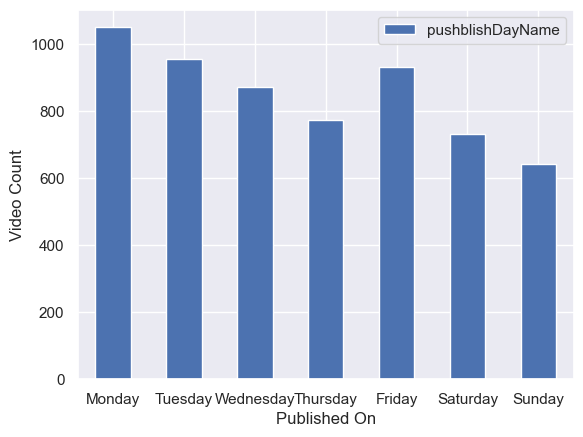

In [123]:
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

day_df = day_df.reindex(weekdays)

ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)

ax.set_xlabel('Published On')
ax.set_ylabel('Video Count')

# 9. No of Tags vs Views

<AxesSubplot:xlabel='tagsCount', ylabel='viewCount'>

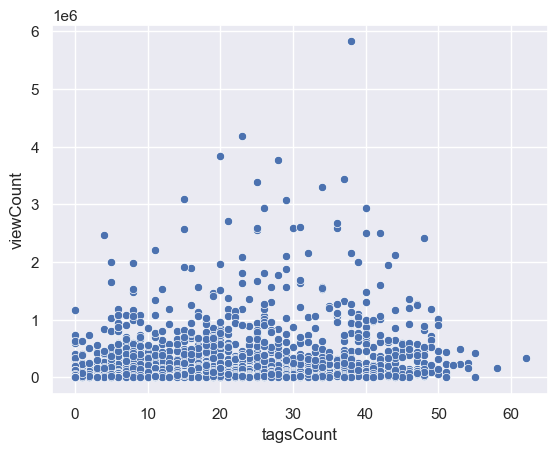

In [124]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")

# 10. Video Titles

In [125]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


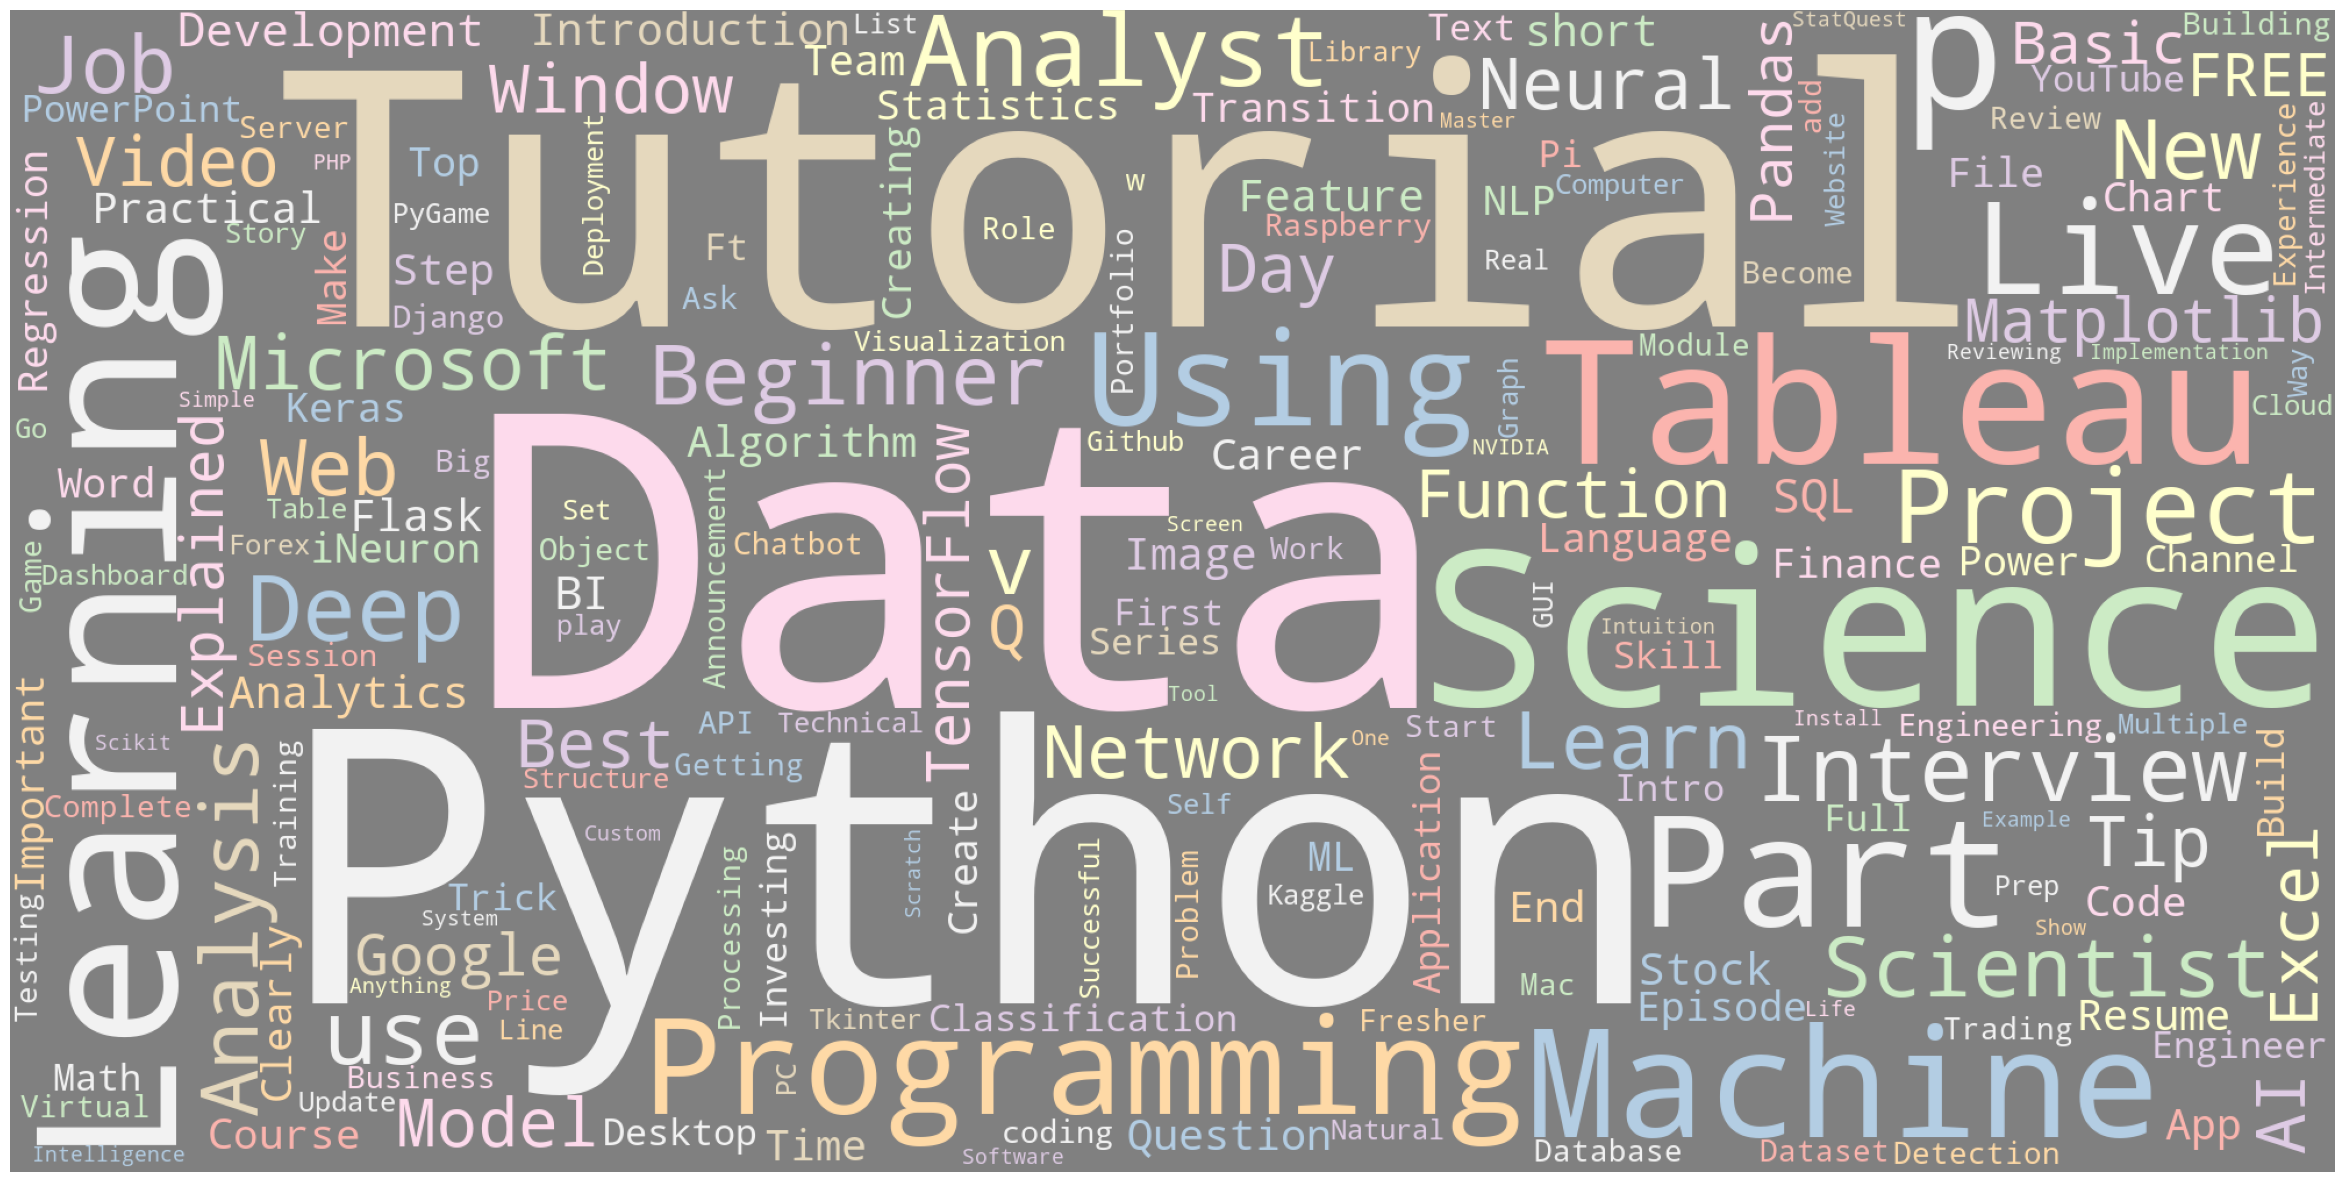

In [126]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='gray', 
                      colormap='Pastel1', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)